# 誤差逆伝播（Backpropagation）

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

## Backwardをスクラッチ実装

- 線形変換のbackwardとRuLUのbackwardの関数を実装
- Loss関数は以前作ったsoftmaxとcross_entropyを使用

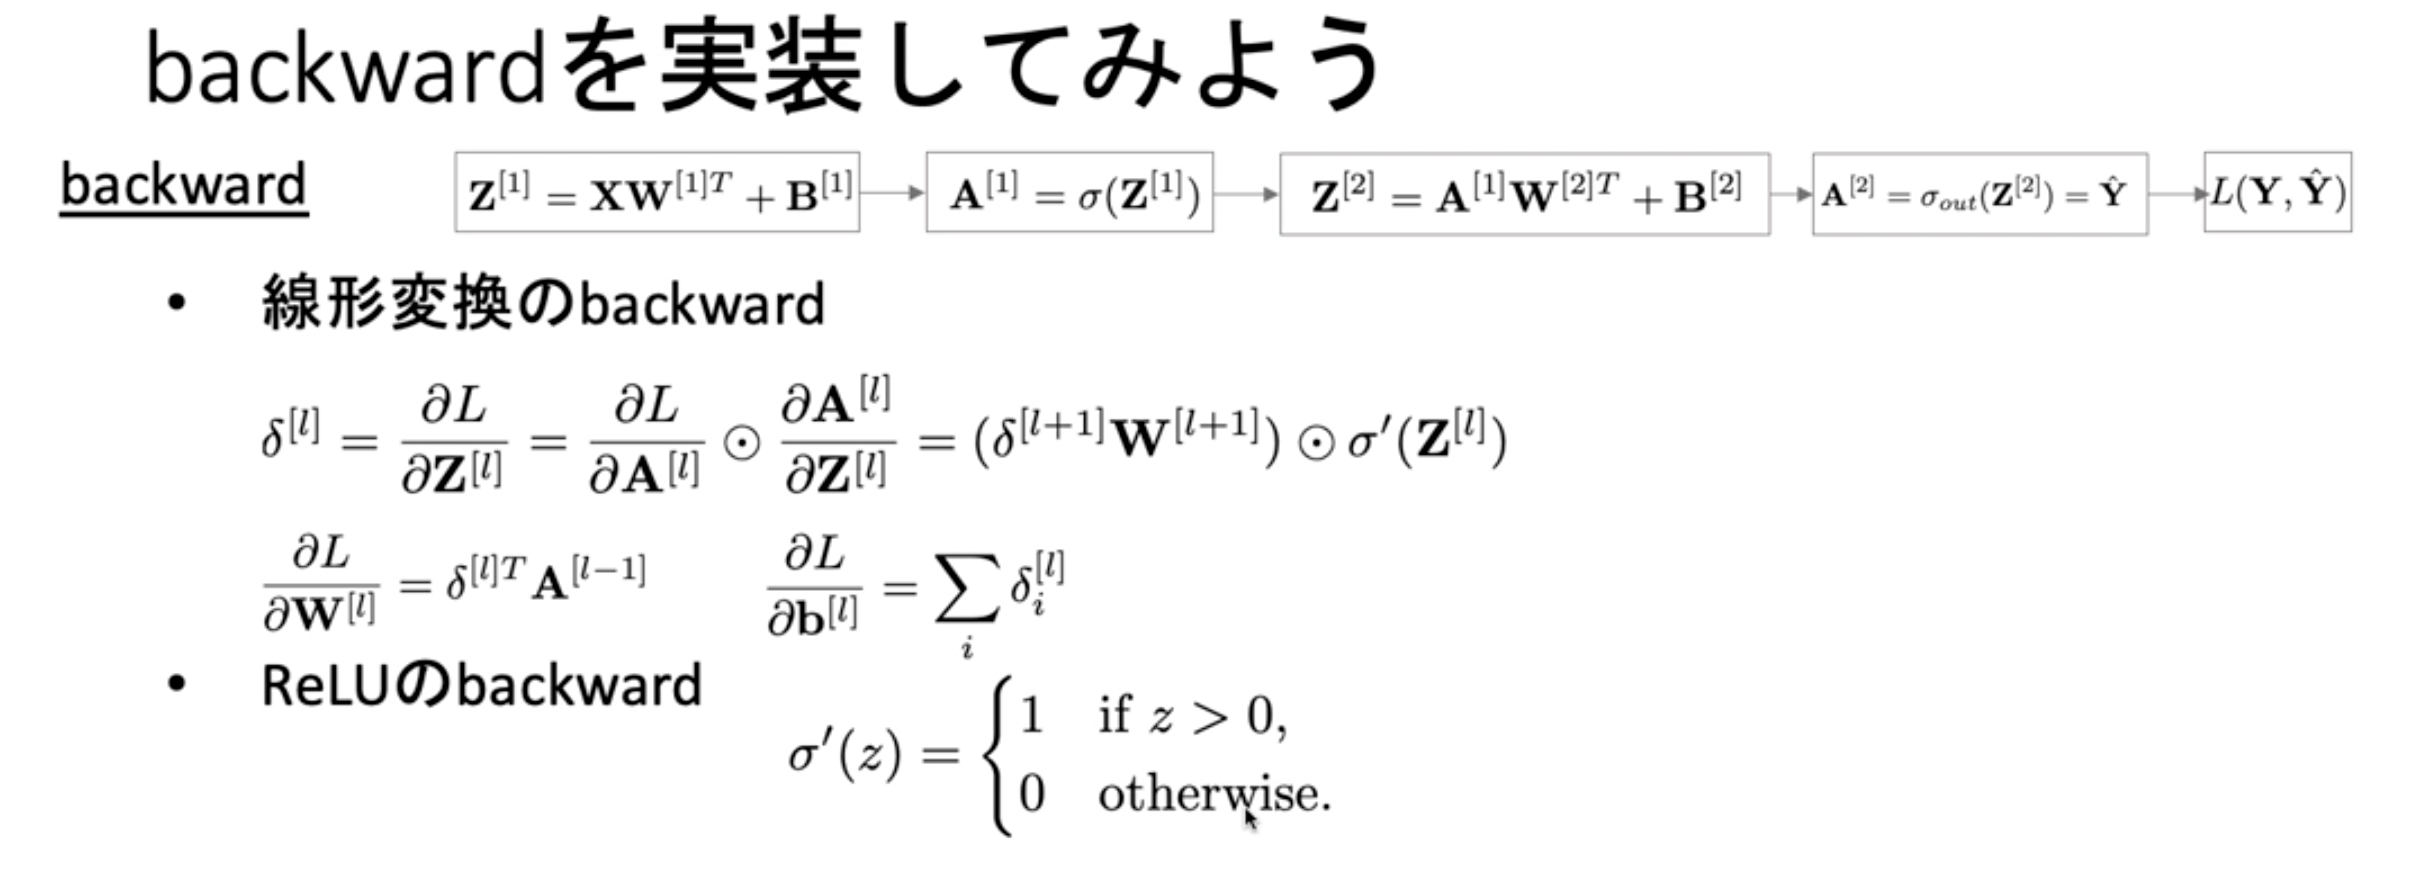

In [2]:
# 線形変換のbackwardとRuLUのbackwardの関数
def linear_backward(A, W, b, Z):
    W.grad_ = Z.grad_.T @ A
    b.grad_ = torch.sum(Z.grad_, dim=0)  # 各データの列方向に対して合計を取る
    A.grad_ = Z.grad_ @ W

def relu_backward(Z, A):
    Z.grad_ = A.grad_ * (Z>0).float()

In [3]:
# b.grad_ = torch.sum(Z.grad_, dim=0) の確認
z = torch.randn((2, 3))
print(z)

torch.sum(z, dim=0)

tensor([[-0.4835,  0.3719,  0.5401],
        [-0.5872,  0.3534,  0.5408]])


tensor([-1.0707,  0.7253,  1.0809])

In [4]:
# Z.grad_ = A.grad_ * (Z>0) の確認
z = torch.randn((2, 3))
print(z)

z>0

tensor([[ 0.2718, -0.6039,  0.9357],
        [ 0.4994,  0.6031,  1.3008]])


tensor([[ True, False,  True],
        [ True,  True,  True]])

In [5]:
# 損失関数L
# softmaxとcrossentropyを同じ関数にする（する必要はないが，pytorchの実装に合わせている
def softmax_and_cross_entropy(x, y_true):
    # softmax
    e_x = torch.exp(x - torch.max(x, dim=-1, keepdim=True)[0])  # 分子
    sum_e_x = torch.sum(e_x, dim=-1, keepdim=True) + 1e-10  # 分母
    softmax_out = e_x / sum_e_x
    # cross_entropy
    loss = -torch.sum(y_true * torch.log(softmax_out + 1e-10)) / y_true.shape[0]

    return loss, softmax_out

In [6]:
# きちんと動くか確かめるために、順伝播(forward)でXから予測Y^を求めて、正解ラベルYとの損失を求める
# その損失から逆伝播（backward）で各勾配を求めていく

# 線形変換(Z=XW.T+b)の関数
def linear(X, W, b):
    return X@W.T + b
    
# ReLU関数
def relu(Z):
    return Z.clamp_min(0.)
    
# 順伝播から予測Y^を作成し逆伝播で勾配を求めていく関数
def forward_and_backward(X, y):
    # forward
    Z1 = linear(X, W1, b1)
    Z1.retain_grad()  # 中間ノードの勾配を保持するため
    A1 = relu(Z1)
    A1.retain_grad()  # 中間ノードの勾配を保持するため
    Z2 = linear(A1, W2, b2)
    Z2.retain_grad()  # 中間ノードの勾配を保持するため
    loss, A2 = softmax_and_cross_entropy(Z2, y)

    # backward
    Z2.grad_ = (A2 - y) / X.shape[0]
    linear_backward(A1, W2, b2, Z2)
    relu_backward(Z1, A1)
    linear_backward(X, W1, b1, Z1)
    
    return loss, Z1, A1, Z2, A2

## Autogradの結果と一致することを確認

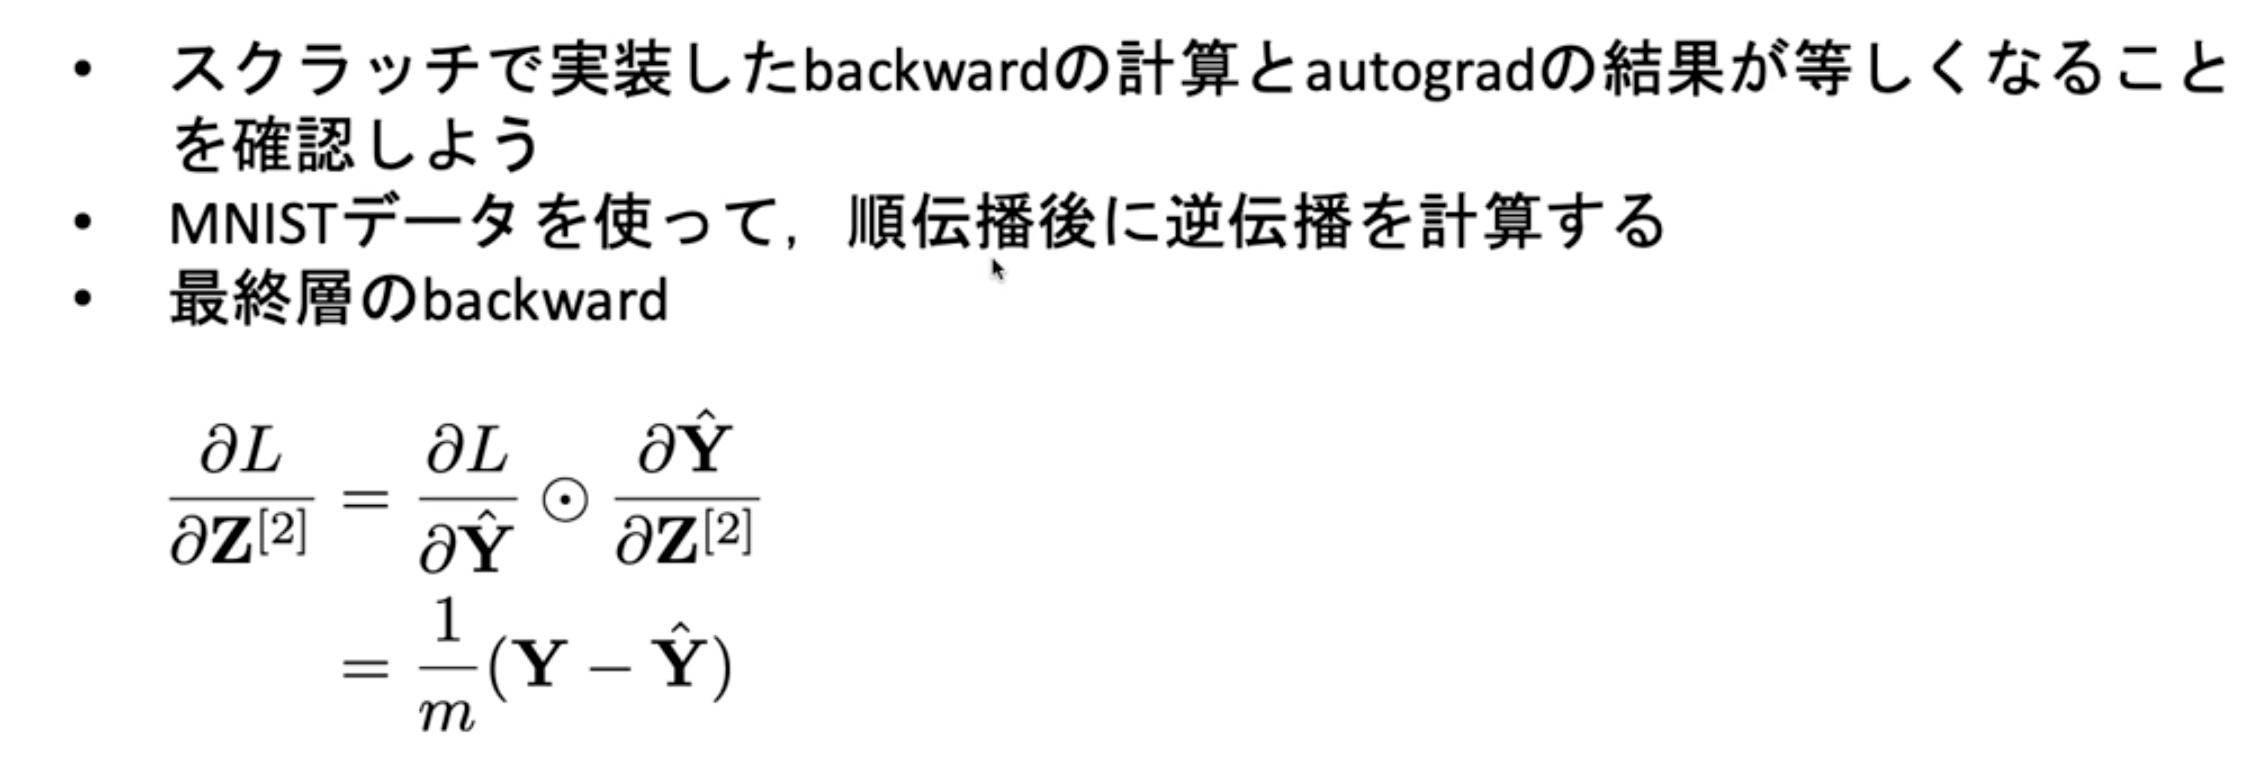

### データ準備

In [7]:
import torch
from sklearn.model_selection import train_test_split
from sklearn import datasets
from torch.nn import functional as F

In [8]:
# データロード
dataset = datasets.load_digits()
images = dataset['images']
target = dataset['target']

# 学習/検証データ分割
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(images, target, test_size=0.2, random_state=42)

# 前処理
from torch.nn import functional as F

# 2-1 モデルのone-hot　encoding
# ｔａｒｇｅｔのonehotでラベル化
y_train = F.one_hot(torch.tensor(y_train), num_classes=10)
y_val = F.one_hot(torch.tensor(y_val), num_classes=10)
# imagesのtensor化
X_train = torch.tensor(X_train, dtype=torch.float32).reshape(-1, 64)
X_val = torch.tensor(X_val, dtype=torch.float32).reshape(-1, 64)

# 2-2 画像の標準化
X_train_mean = X_train.mean()
X_train_std = X_train.std()
X_train = (X_train - X_train_mean) / X_train_std
X_val = (X_val - X_train_mean) / X_train_std

In [9]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

torch.Size([1437, 64])
torch.Size([360, 64])
torch.Size([1437, 10])
torch.Size([360, 10])


### パラメータ初期化

In [10]:
# パラメータ初期化
m, n = X_train.shape  # m:データ数、n特徴量数
nh = 30  # nh:隠れ層の数
class_num = 10  # 

## 1層目のW1,b1
# W1 = torch.randn((nh, n), requires_grad=True) # 出力 x 入力
# Kaiming初期化を使って，softmaxの入力が大きくならないようにする
W1 = torch.randn((nh, n)) * torch.sqrt(torch.tensor(2./n))
W1.requires_grad = True
ｂ1 = torch.zeros((1, nh), requires_grad=True)  # 1 X nh, biasは最初の初期値を0にすることがあるので0ベクトルにしておく

## 2層目のW2,b2
# W2 = torch.randn((class_num, nh), requires_grad=True) # 出力 x 入力
# Kaiming初期化を使って，softmaxの入力が大きくならないようにする
W2 = torch.randn((class_num, nh)) * torch.sqrt(torch.tensor(2./nh))
W2.requires_grad = True
ｂ2 = torch.zeros((1, class_num), requires_grad=True)  # 1 X nh

### 損失計算

In [11]:
loss, Z1, A1, Z2, A2 = forward_and_backward(X_train, y_train)

### スクラッチ実装した勾配とAutogradで等しくなることを確認
- Z2は合っているデータもあれば、合ってないデータもある
- パラメータ初期化を工夫することで、Z2が大きくならないのでスクラッチ実装した勾配とAutogradの勾配が等しくすることができる

In [12]:
# スクラッチ実装
Z2.grad_

tensor([[ 1.6301e-04,  8.7524e-06,  4.7966e-05,  ...,  7.7465e-05,
          3.6927e-05,  1.3552e-05],
        [-6.4879e-04,  2.0215e-05,  1.8603e-04,  ...,  1.6719e-05,
          1.2670e-04,  1.4757e-05],
        [-6.3449e-04,  4.7542e-05,  5.2921e-05,  ...,  1.6912e-05,
          2.1608e-04,  1.0973e-05],
        ...,
        [ 1.7861e-04,  1.3263e-05, -5.7272e-04,  ...,  4.8792e-06,
          3.7626e-05,  9.5797e-05],
        [ 1.0524e-04,  4.1955e-05,  5.8805e-05,  ..., -6.9004e-04,
          2.0066e-04,  2.3625e-05],
        [ 2.4498e-05, -6.2799e-04,  9.4486e-06,  ...,  1.9061e-05,
          3.1297e-04,  1.4163e-05]], grad_fn=<DivBackward0>)

In [13]:
# Autograd
loss.backward()

In [14]:
Z2.grad

tensor([[ 1.6301e-04,  8.7524e-06,  4.7966e-05,  ...,  7.7465e-05,
          3.6927e-05,  1.3552e-05],
        [-6.4879e-04,  2.0215e-05,  1.8603e-04,  ...,  1.6719e-05,
          1.2670e-04,  1.4757e-05],
        [-6.3449e-04,  4.7542e-05,  5.2921e-05,  ...,  1.6912e-05,
          2.1608e-04,  1.0973e-05],
        ...,
        [ 1.7861e-04,  1.3263e-05, -5.7272e-04,  ...,  4.8792e-06,
          3.7626e-05,  9.5797e-05],
        [ 1.0524e-04,  4.1955e-05,  5.8805e-05,  ..., -6.9004e-04,
          2.0066e-04,  2.3625e-05],
        [ 2.4498e-05, -6.2799e-04,  9.4486e-06,  ...,  1.9061e-05,
          3.1297e-04,  1.4163e-05]])

In [15]:
W2.grad_[:4]

tensor([[ 6.7555e-03,  3.5708e-02,  1.1611e-02,  1.4525e-01, -7.4281e-03,
          3.7430e-02,  3.3276e-03,  9.8025e-03,  2.1445e-02, -6.5546e-02,
         -5.3451e-04,  1.8463e-02,  1.8153e-02,  3.6411e-02,  1.8083e-02,
          4.9735e-03, -4.8226e-03,  3.7309e-03,  9.4471e-03, -2.9647e-02,
          5.2772e-02, -7.8484e-05, -5.8789e-02,  6.1344e-02,  1.9582e-02,
          2.0403e-02,  4.0401e-02,  2.0214e-02,  2.6710e-02, -5.1323e-02],
        [-3.4686e-02, -5.5543e-02,  3.0499e-03, -1.1835e-01, -1.1927e-01,
         -2.6221e-02, -6.0016e-03, -2.4457e-02, -8.2727e-02, -2.9446e-02,
          1.0478e-04,  4.3938e-03,  3.5691e-03, -1.8528e-02, -2.3924e-02,
         -1.6781e-03, -7.8799e-02, -5.5807e-04, -2.1999e-03, -1.9837e-02,
         -6.9761e-02,  5.5120e-06,  6.8662e-03, -6.8766e-02, -4.6730e-02,
         -2.8450e-02, -1.3443e-02, -7.1176e-02, -2.5420e-02, -5.2767e-02],
        [-3.9225e-03, -8.7346e-02,  3.6527e-03, -8.2918e-03,  1.1041e-01,
          1.4304e-02,  9.2450e-03,  

In [16]:
W2.grad[:4]

tensor([[ 6.7555e-03,  3.5708e-02,  1.1611e-02,  1.4525e-01, -7.4281e-03,
          3.7430e-02,  3.3276e-03,  9.8025e-03,  2.1445e-02, -6.5546e-02,
         -5.3451e-04,  1.8463e-02,  1.8153e-02,  3.6411e-02,  1.8083e-02,
          4.9735e-03, -4.8226e-03,  3.7309e-03,  9.4471e-03, -2.9647e-02,
          5.2772e-02, -7.8484e-05, -5.8789e-02,  6.1344e-02,  1.9582e-02,
          2.0403e-02,  4.0401e-02,  2.0214e-02,  2.6710e-02, -5.1323e-02],
        [-3.4686e-02, -5.5543e-02,  3.0499e-03, -1.1835e-01, -1.1927e-01,
         -2.6221e-02, -6.0016e-03, -2.4457e-02, -8.2727e-02, -2.9446e-02,
          1.0478e-04,  4.3938e-03,  3.5691e-03, -1.8528e-02, -2.3924e-02,
         -1.6781e-03, -7.8799e-02, -5.5807e-04, -2.1999e-03, -1.9837e-02,
         -6.9761e-02,  5.5120e-06,  6.8662e-03, -6.8766e-02, -4.6730e-02,
         -2.8450e-02, -1.3443e-02, -7.1176e-02, -2.5420e-02, -5.2767e-02],
        [-3.9225e-03, -8.7346e-02,  3.6527e-03, -8.2918e-03,  1.1041e-01,
          1.4304e-02,  9.2450e-03,  

In [17]:
Z2

tensor([[ 1.5847, -1.3398,  0.3614,  ...,  0.8407,  0.0999, -0.9026],
        [-0.5904, -1.4364,  0.7831,  ..., -1.6263,  0.3990, -1.7511],
        [-0.0912, -0.3471, -0.2399,  ..., -1.3807,  1.1669, -1.8132],
        ...,
        [ 0.8001, -1.8001,  0.4285,  ..., -2.8001, -0.7574,  0.1771],
        [ 0.3859, -0.5337, -0.1961,  ..., -2.5023,  1.0313, -1.1080],
        [-0.5991,  0.4204, -1.5518,  ..., -0.8501,  1.9484, -1.1471]],
       grad_fn=<AddBackward0>)

In [18]:
X_train

tensor([[-0.8119, -0.8119, -0.3139,  ...,  1.3459, -0.1479, -0.8119],
        [-0.8119, -0.8119,  0.6820,  ..., -0.3139, -0.8119, -0.8119],
        [-0.8119, -0.8119, -0.8119,  ...,  0.1840, -0.8119, -0.8119],
        ...,
        [-0.8119, -0.8119,  0.6820,  ...,  1.8439, -0.4799, -0.8119],
        [-0.8119, -0.8119, -0.6459,  ..., -0.8119, -0.8119, -0.8119],
        [-0.8119, -0.8119, -0.6459,  ..., -0.6459, -0.8119, -0.8119]])

### パラメータ初期化から比較まで1コードで記載

In [19]:
# パラメータの初期化
m, n = X_train.shape
nh = 30
class_num = 10
# パラメータの初期化
# W1 = torch.randn((nh, n), requires_grad=True) # 出力 x 入力
# Kaiming初期化を使って，softmaxの入力が大きくならないようにする
W1 = torch.randn((nh, n)) * torch.sqrt(torch.tensor(2./n))
W1.requires_grad = True
b1 = torch.zeros((1, nh), requires_grad=True) # 1 x nh

# W2 = torch.randn((class_num, nh), requires_grad=True) # 出力 x 入力
# Kaiming初期化を使って，softmaxの入力が大きくならないようにする
W2 = torch.randn((class_num, nh)) * torch.sqrt(torch.tensor(2./nh))
W2.requires_grad = True
b2 = torch.zeros((1, class_num), requires_grad=True) # 1 x nh
# スクラッチのbackward
loss, Z1, A1, Z2, A2 = forward_and_backward(X_train, y_train)
# PytorchのAutograd
loss.backward()

# autogradと等しいことを確認
# allcloseは2つの勾配が大体同じであるかを返す関数
print(torch.allclose(W1.grad_, W1.grad))
print(torch.allclose(b1.grad_, b1.grad))
print(torch.allclose(W2.grad_, W2.grad))
print(torch.allclose(b2.grad_, b2.grad))

True
True
True
True


## backwardをMLPの学習ループに組み込む
- 以前作成した学習ループに、前レクチャーで作成したbackwardのコードを組み込んで、実際にパラメータを更新してMLPを学習させる

In [20]:
###################### MLPで実装 ######################## 

loss_log = []
learning_rate = 0.03

# パラメータ初期化  ###################### MLPのパラメータ初期化 ########################
# W = torch.rand((10, 64), requires_grad=True)  # 出力 x 入力
# b = torch.rand((1, 10), requires_grad=True)  # 1 x 出力
W1 = torch.randn((nh, n)) * torch.sqrt(torch.tensor(2./n))
W1.requires_grad = True
b1 = torch.zeros((1, nh), requires_grad=True) # 1 x nh
W2 = torch.randn((class_num, nh)) * torch.sqrt(torch.tensor(2./nh))
W2.requires_grad = True
b2 = torch.zeros((1, class_num), requires_grad=True) # 1 x nh

# バッチサイズとミニバッチの個数を設定
batch_size = 30
num_batches = np.ceil(len(y_train) /batch_size).astype(int)

# ログ
train_losses = []
val_losses = []
val_accuracies = []

# for文で学習ループ作成
for epoch in range(30):
    shuffled_indices = np.random.permutation(len(y_train))
    running_loss = 0
    for i in range(num_batches):

        # mini batch作成
        start = i * batch_size
        end = start + batch_size
        batch_indices = shuffled_indices[start:end]
        
        # 入力データXおよび教師ラベルのYを作成
        y_true_ = y_train[batch_indices, :] # データ数xクラス数
        X = X_train[batch_indices, :] # データ数 x 特徴量数
        
        # Zの計算(Z=X*W^t+b)
        # Z = X@W.T + b  ###################### ロジスティック回帰の式を2層MLPで実装 ########################
        Z1 = linear(X, W1, b1)
        Z1.retain_grad()
        A1 = relu(Z1)
        A1.retain_grad()
        Z2 = linear(A1, W2, b2)
        Z2.retain_grad()
        loss, A2 = softmax_and_cross_entropy(Z2, y_true_)

        # softmaxで予測計算
        # y_pred = softmax(Z)

        # 損失計算
        # loss = cross_entropy(y_true_, y_pred)  ###################### softmax_and_cross_entropy ########################
        loss_log.append(loss.item())  # lossはtensorの形になっているので.itemで値だけ取るようにする
        running_loss += loss.item()

        # 勾配計算
        # loss.backward()　　###################### スクラッチのbackward ########################
        Z2.grad_ = (A2 - y_true_) / X.shape[0]
        linear_backward(A1, W2, b2, Z2)
        relu_backward(Z1, A1)
        linear_backward(X, W1, b1, Z1)

        # パラメータ更新
        with torch.no_grad():
            # W -= learning_rate * W.grad  ###################### .grad -> .grad_ ########################
            # b -= learning_rate * b.grad  ###################### .grad -> .grad_ ########################
            W1 -= learning_rate * W1.grad_
            W2 -= learning_rate * W2.grad_
            b1 -= learning_rate * b1.grad_
            b2 -= learning_rate * b2.grad_

        # 勾配初期化
        # W.grad.zero_()  ###################### .grad -> None ########################
        # b.grad.zero_()  ###################### .grad -> None ########################
            W1.grad_ = None
            W2.grad_ = None
            b1.grad_ = None
            b2.grad_ = None

    # validation:同様に出力結果Z,softmax計算,損失計算,最後にAccuracyを計算。validationでは勾配計算をする必要がない
    # また、学習データではミニバッチでデータを分割し実施していたが、検証データでは一括で実施していることに注意
    with torch.no_grad():
        # Z_val = X_val@W.T + b  ###################### ここをMLPで実装 ########################
        Z1_val = linear(X_val, W1, b1)
        A1_val = relu(Z1_val)
        Z2_val = linear(A1_val, W2, b2)
        val_loss, A2_val = softmax_and_cross_entropy(Z2_val, y_val)
        # y_pred_val = softmax(Z_val)
        # y_pred_val = softmax(Z_val)
        # val_loss = cross_entropy(y_val, y_pred_val)  ###################### softmax_and_cross_entropy ########################
        
        # Accuracy
        val_accuracy = torch.sum(torch.argmax(A2_val, dim=-1) == torch.argmax(y_val, dim=-1)) / y_val.shape[0]

    train_losses.append(running_loss/num_batches)
    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy.item())

    # 損失ログの出力
    print(f'epoch {epoch+1}: {running_loss/num_batches}, val loss: {val_loss.item()}, val accuracy: {val_accuracy}')

epoch 1: 1.8759262536962826, val loss: 1.298486351966858, val accuracy: 0.699999988079071
epoch 2: 0.9596835461755594, val loss: 0.7208709716796875, val accuracy: 0.875
epoch 3: 0.5779119338840246, val loss: 0.49266621470451355, val accuracy: 0.9111111164093018
epoch 4: 0.4102310848732789, val loss: 0.38827621936798096, val accuracy: 0.9111111164093018
epoch 5: 0.3274554343273242, val loss: 0.31454187631607056, val accuracy: 0.9166666865348816
epoch 6: 0.27578202697137993, val loss: 0.2811717689037323, val accuracy: 0.9277777671813965
epoch 7: 0.2423035978960494, val loss: 0.2502301037311554, val accuracy: 0.9305555820465088
epoch 8: 0.21601716925700506, val loss: 0.23241795599460602, val accuracy: 0.9388889074325562
epoch 9: 0.19804020132869482, val loss: 0.21083039045333862, val accuracy: 0.9361110925674438
epoch 10: 0.18218384915962815, val loss: 0.20059099793434143, val accuracy: 0.9444444179534912
epoch 11: 0.16815762353750566, val loss: 0.18979600071907043, val accuracy: 0.941666

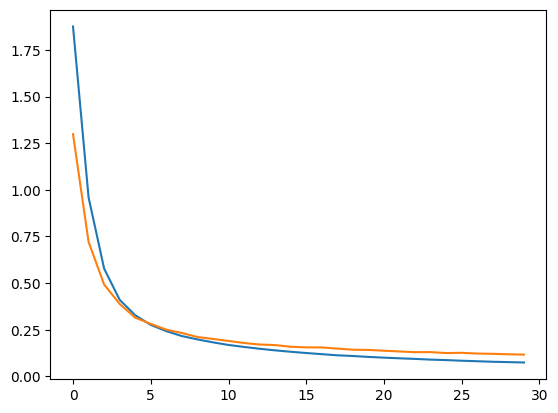

In [21]:
plt.plot(train_losses)
plt.plot(val_losses)

## 回帰のbackpropagation

回帰2層NNモデルのforwardとbackward

- 分類タスクと比較した時、損失関数の勾配が変更されることに注意
- スクラッチ実装したbackwardの計算とautogradの結果が等しくなることを確認する
- 回帰NNは分類NNで損失関数Lでsoftmax＆cross entoropy使っていた部分がMSEになる。勾配の式も変更される。

In [23]:
# y_trainのデータがone-hotされてるので、元に戻す
y_train_reg = torch.argmax(y_train, dim=-1)

# 損失関数がMSEになるので新たに定義する
def mse(X, y):
    return (X[:, 0] - y).pow(2).mean()

In [30]:
# y_trainがone-hotの形になっているので元に戻す
y_train_reg = torch.argmax(y_train, dim=-1)

# 回帰NNの損失関数はMSEなので新たに定義する
def mse(X, y):
    return (X[:, 0] - y).pow(2).mean()

# 回帰用のforward_and_backward関数
def forward_and_backward(X, y):
    # forward
    Z1 = linear(X, W1, b1)
    Z1.retain_grad()
    A1 = relu(Z1)
    A1.retain_grad()
    Z2 = linear(A1, W2, b2)
    Z2.retain_grad()
    # loss, A2 = softmax_cross_entropy(Z2, y) # -> MSE
    loss = mse(Z2, y)

    # backward
    # Z2.grad_ = (A2 - y) / X.shape[0] # -> MSE
    Z2.grad_ = 2 * (Z2 - y.unsqueeze(dim=-1)) / X.shape[0]
    linear_backward(A1, W2, b2, Z2)
    relu_backward(Z1, A1)
    linear_backward(X, W1, b1, Z1)
    return loss, Z1, A1, Z2, A2

# パラメータの初期化
m, n = X_train.shape
nh = 30
# パラメータの初期化
W1 = torch.randn((nh, n), requires_grad=True) # 出力 x 入力
b1 = torch.zeros((1, nh), requires_grad=True) # 1 x nh
W2 = torch.randn((1, nh), requires_grad=True) # 出力 x 入力
b2 = torch.zeros((1, 1), requires_grad=True) # 1 x nh
# スクラッチのbackward
loss, Z1, A1, Z2, A2 = forward_and_backward(X_train, y_train_reg)
# PytorchのAutograd
loss.backward()

# autogradと等しいことを確認
# allcloseは2つの勾配が大体同じであるかを返す関数
print(torch.allclose(W1.grad_, W1.grad))
print(torch.allclose(b1.grad_, b1.grad))
print(torch.allclose(W2.grad_, W2.grad))
print(torch.allclose(b2.grad_, b2.grad))

True
True
True
True


## Refactoring

- 各Layerをクラス化する
    - Linearクラス
    - ReLUクラス
    - SoftmaxとCrossEntoropy
- 両クラスとも以下のメソッドを実装する
    - forwardメソッド：順伝播を計算（入力Xを引数）
    - backwardメソッド:逆伝播を計算（出力Z,Aを引数）
- Modelクラスを作成する
    - 各Layerクラスを使ってモデルを構築する
    - zero_gradメソッド：勾配をリセット
    - stepメソッド：パラメータを更新

In [43]:
# ======モデル======
class Linear():
    def __init__(self, in_features, out_features):
        self.W = torch.randn((out_features, in_features)) * torch.sqrt(torch.tensor(2.0 / in_features))
        self.W.requires_grad = True
        self.b = torch.zeros((1, out_features), requires_grad=True)

    # 順伝播は入力をXでZを出力する
    def forward(self, X):
        self.X = X
        self.Z = X @ self.W.T + self.b
        return self.Z

    # 逆伝播は入力をZとしてXとbの勾配が出力
    def backward(self, Z):
        self.W.grad_ = self.Z.grad_.T @ self.X
        self.b.grad_ = torch.sum(self.Z.grad_, dim=0)  # 各データの列方向に対して合計を取る
        self.X.grad_ = self.Z.grad_ @ self.W
        return self.X.grad_


class ReLU():
    def forward(self, X):
        self.X = X
        return X.clamp_min(0.)

    def backward(self, A):
         return A.grad_ * (self.X>0).float()


class SoftmaxCrossEntropy():
    def forward(self, X, y):
        # softmax
        e_x = torch.exp(X - torch.max(X, dim=-1, keepdim=True)[0])  # 分子
        sum_e_x = torch.sum(e_x, dim=-1, keepdim=True) + 1e-10  # 分母
        self.softmax_out = e_x / sum_e_x
        # cross_entropy
        self.loss = -torch.sum(y * torch.log(self.softmax_out + 1e-10)) / y.shape[0]
    
        return self.loss

    def backward(self, y):
        return (self.softmax_out - y) / y.shape[0]


class Model:
    def __init__(self, input_features, hidden_units, output_units, data_num):
        '''
            input_features:入力の次元
            hidden_units:隠れ層のニューロンの数
            output_units:出力の次元
            data_num:データ数
        '''
        self.linear1 = Linear(input_features, hidden_units)  # 隠れ層の線形変換
        self.relu = ReLU()  # 隠れ層のReLUの変換
        self.linear2 = Linear(hidden_units, output_units)  # 出力層の線形変換
        self.loss_fn = SoftmaxCrossEntropy()  #  出力層の損失関数

    def forward(self, X, y):
        self.X = X
        self.Z1 = self.linear1.forward(X)
        self.A1 = self.relu.forward(self.Z1)
        self.Z2 = self.linear2.forward(self.A1)
        self.loss = self.loss_fn.forward(self.Z2, y)
        return self.loss, self.Z2

    def backward(self, y):
        self.Z2.grad_ = self.loss_fn.backward(y)
        self.A1.grad_ = self.linear2.backward(self.Z2)
        self.Z1.grad_ = self.relu.backward(self.A1)
        self.X.grad_ = self.linear1.backward(self.Z1)    

    def zero_grad(self):
        # 勾配の初期化
        self.linear1.W.grad_ = None
        self.linear1.b.grad_ = None
        self.linear2.W.grad_ = None
        self.linear2.b.grad_ = None
        
    def step(self, learning_rate):
        # パラメータの更新
        self.linear1.W -= learning_rate * self.linear1.W.grad_
        self.linear1.b -= learning_rate * self.linear1.b.grad_
        self.linear2.W -= learning_rate * self.linear2.W.grad_
        self.linear2.b -= learning_rate * self.linear2.b.grad_
        

In [44]:
## Refactoring後の学習ループ(OptimizerやDataset, Dataloaderは後ほどRefactoring)
# ===データの準備====
dataset = datasets.load_digits()
data = dataset['data']
target = dataset['target']
images = dataset['images']
X_train, X_val, y_train, y_val = train_test_split(images, target, test_size=0.2, random_state=42)
X_train = (X_train - X_train.mean()) / X_train.std()
X_val = (X_val - X_train.mean()) / X_train.std()
X_train = torch.tensor(X_train.reshape(-1, 64), dtype=torch.float32)
X_val = torch.tensor(X_val.reshape(-1, 64), dtype=torch.float32)
y_train = F.one_hot(torch.tensor(y_train), num_classes=10) #1437 x 10 
y_val = F.one_hot(torch.tensor(y_val), num_classes=10) # 360 x 10
batch_size = 30
# モデルの初期化
model = Model(input_features=64, hidden_units=10, output_units=10, data_num=batch_size)

learning_rate = 0.01

# ログ
train_losses = []
val_losses = []
val_accuracies = []
for epoch in range(100):
    # エポック毎にデータをシャッフル
    shuffled_indices = np.random.permutation(len(y_train))
    num_batches = np.ceil(len(y_train)/batch_size).astype(int)
    running_loss = 0.0
    
    for i in range(num_batches):
        
        # mini batch作成
        start = i * batch_size
        end = start + batch_size

        batch_indices = shuffled_indices[start:end]
        y_true_ = y_train[batch_indices, :] # batch_size x 10
        
        X = X_train[batch_indices] # batch_size x 64
        # 順伝播と逆伝播の計算
        loss, _ = model.forward(X, y_true_)
        model.backward(y_true_)
        running_loss += loss.item()

        # パラメータ更新
        with torch.no_grad():
            model.step(learning_rate)

        model.zero_grad()

    # validation
    with torch.no_grad():
        val_loss, Z2_val = model.forward(X_val, y_val)
        
        val_accuracy = torch.sum(torch.argmax(Z2_val, dim=-1) == torch.argmax(y_val, dim=-1)) / y_val.shape[0]

    train_losses.append(running_loss/num_batches)
    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy)
    print(f'epoch: {epoch}: train error: {running_loss/num_batches}, validation error: {val_loss.item()}, validation accuracy: {val_accuracy}')

epoch: 0: train error: 2.6388325293858848, validation error: 10.155607223510742, validation accuracy: 0.0694444477558136
epoch: 1: train error: 2.130353959898154, validation error: 7.939568519592285, validation accuracy: 0.16944444179534912
epoch: 2: train error: 1.9229546089967091, validation error: 6.801773548126221, validation accuracy: 0.22499999403953552
epoch: 3: train error: 1.760911042491595, validation error: 6.158058166503906, validation accuracy: 0.26944443583488464
epoch: 4: train error: 1.6189825336138408, validation error: 5.621041297912598, validation accuracy: 0.2944444417953491
epoch: 5: train error: 1.4746144438783328, validation error: 4.937144756317139, validation accuracy: 0.3361110985279083
epoch: 6: train error: 1.327447031935056, validation error: 4.254913806915283, validation accuracy: 0.4138889014720917
epoch: 7: train error: 1.180626713981231, validation error: 3.4422824382781982, validation accuracy: 0.5
epoch: 8: train error: 1.042698395748933, validation e

[W PyInterpreter.cpp:221] Warning: Deallocating Tensor that still has live PyObject references.  This probably happened because you took out a weak reference to Tensor and didn't call _fix_weakref() after dereferencing it.  Subsequent accesses to this tensor via the PyObject will now fail. (function decref)


epoch: 78: train error: 0.11384415948608269, validation error: 1.1509661674499512, validation accuracy: 0.8972222208976746
epoch: 79: train error: 0.11253722729937483, validation error: 1.0622268915176392, validation accuracy: 0.8999999761581421
epoch: 80: train error: 0.1116818996767203, validation error: 1.1582411527633667, validation accuracy: 0.8999999761581421
epoch: 81: train error: 0.11094410244065027, validation error: 1.132988691329956, validation accuracy: 0.8999999761581421
epoch: 82: train error: 0.10960917586150269, validation error: 1.1304477453231812, validation accuracy: 0.8999999761581421
epoch: 83: train error: 0.10839641280472279, validation error: 1.0924495458602905, validation accuracy: 0.8999999761581421
epoch: 84: train error: 0.10742648299007367, validation error: 1.1594014167785645, validation accuracy: 0.894444465637207
epoch: 85: train error: 0.10626392287667841, validation error: 1.1581428050994873, validation accuracy: 0.8972222208976746
epoch: 86: train er